In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import combinations

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel
from gammapy.irf import EDispKernel, PSFMap
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion
from hawc_dataset import HAWCMapDataset
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
)
from gammapy.modeling.models import Models
sys.path.append('utils/')
from vikas_utils import get_excluded_regions

#### Model Definition

In [3]:
spatial_model = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="7 TeV"
)

spectral_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model.beta.error = 0.015
spectral_model.alpha.error = 0.019

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='crab model')

#### hess semi-stacked datasets

In [4]:
%%time
models = Models([])
datasets_hess = []
for i in range(5):
    dataset = MapDataset.read('/lfs/l2/hawc/users/vikasj78/gammapyData/crabCustomEBins/dataset-bkg-fit-stacked-thresh-{:02d}.fits.gz'.format(i))
    dataset._models = models.copy()
    dataset.models.append(model)
    datasets_hess.append(dataset)

CPU times: user 3.33 s, sys: 211 ms, total: 3.54 s
Wall time: 3.91 s


#### hawc event-class datasets

In [6]:
%%time
datasets_hawc = []
for i in range(1,10):
    dataset =  HAWCMapDataset.read('/lfs/l7/hawc/hawc-gammapy-verification/point_source/gammapy_dataset_vikas/crab-{}nHitBin.fits.gz'.format(i))
    dataset._models = models.copy()
    dataset.models.append(model)
    datasets_hawc.append(dataset)

CPU times: user 1min 47s, sys: 6.7 s, total: 1min 53s
Wall time: 2min 6s


#### Fitting Joint

In [31]:
%%time
# Perform fit
datasets_hess_and_hawc = datasets_hess + datasets_hawc
fit_joint = Fit(datasets_hess_and_hawc)
result_joint = fit_joint.run(optimize_opts=dict(print_level=1))

------------------------------------------------------------------
| FCN = -1.703E+08              |      Ncalls=78 (78 total)      |
| EDM = 0.574 (Goal: 1E-05)     |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 2min 27s, sys: 1min 28s, total: 3min 55s
Wall time: 4min 1s


In [32]:
result_joint.parameters.to_table().show_in_notebook()

idx,name,value,unit,min,max,frozen,error
0,amplitude,2.2746e-13,cm-2 s-1 TeV-1,nan,nan,False,5.164e-15
1,reference,7.0000e+00,TeV,nan,nan,True,0.000e+00
2,alpha,2.7888e+00,,nan,nan,False,2.429e-02
3,beta,9.9567e-02,,nan,nan,False,9.034e-03
4,lon_0,8.3632e+01,deg,nan,nan,False,2.382e-03
5,lat_0,2.2025e+01,deg,-9.000e+01,9.000e+01,False,1.973e-03


#### Getting flux points

In [34]:
%%time
#Joint flux points
eaxis = MapAxis.from_edges(
        [0.316,0.562,1.00,1.78,3.16,5.62,10.0,17.8,31.6,56.2,100,177,316] * u.TeV,
        name="energy",
        interp="log"
    )
flux_points_joint = FluxPointsEstimator(energy_edges=eaxis.edges,source="crab model").run(datasets_hess_and_hawc)
flux_points_joint.table["is_ul"] = flux_points_joint.table["ts"] < 4

CPU times: user 14min 39s, sys: 12min 3s, total: 26min 43s
Wall time: 26min 49s


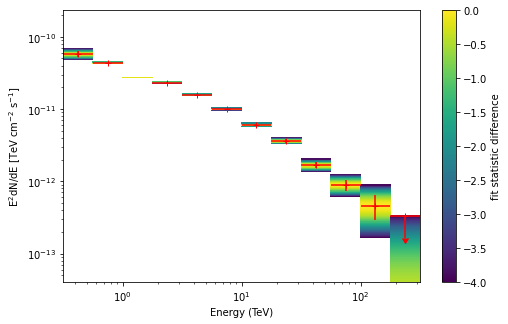

In [36]:
plt.figure(figsize=(8, 5))
ax = flux_points_joint.plot(
    energy_power=2, color="red"
)
flux_points_joint.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, cmap='viridis',  y_unit="TeV cm-2 s-1")
ax.set_ylabel("E$^2$dN/dE [TeV cm$^{-2}$ s$^{-1}$]")
plt.savefig("plots/hawc_hess_joint_flux_points.png", dpi=300, bbox_inches='tight')

In [37]:
%%time
#HESS flux points
ebins = np.array([0.316,0.422,0.562,0.750,1.00,1.33,1.78,2.37,3.16,4.22,5.62,7.50,10.0,13.3,17.8,23.7,31.6,42.1,56.2,75.0,100])
eaxis = MapAxis.from_edges(
        ebins * u.TeV,
        name="energy",
        interp="log"
    )
flux_points_hess = FluxPointsEstimator(energy_edges=eaxis.edges,  source="crab model").run(datasets_hess)
flux_points_hess.table["is_ul"] = flux_points_hess.table["ts"] < 4

CPU times: user 1min 49s, sys: 9.41 s, total: 1min 58s
Wall time: 2min 2s


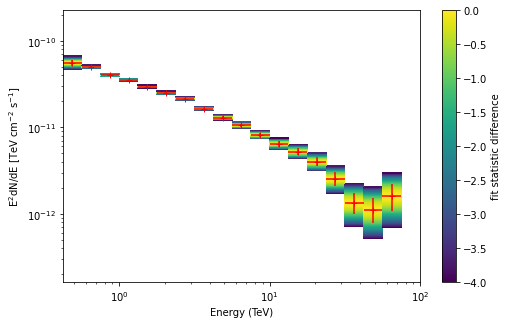

In [38]:
flux_points_hess.table.remove_row(0)
plt.figure(figsize=(8, 5))
ax = flux_points_hess.plot(
    energy_power=2, color="red"
)
flux_points_hess.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, cmap='viridis',  y_unit="TeV cm-2 s-1")
ax.set_ylabel("E$^2$dN/dE [TeV cm$^{-2}$ s$^{-1}$]")
plt.savefig("plots/hess_flux_points.png", dpi=300, bbox_inches='tight')

In [39]:
%%time
#HAWC flux points
eaxis = MapAxis.from_bounds(1.00, 316, nbin=10, name="energy", interp="log", unit="TeV")
flux_points_hawc = FluxPointsEstimator(energy_edges=eaxis.edges,  source="crab model").run(datasets_hawc)
flux_points_hawc.table["is_ul"] = flux_points_hawc.table["ts"] < 4

CPU times: user 16min 20s, sys: 14min 37s, total: 30min 58s
Wall time: 31min 10s


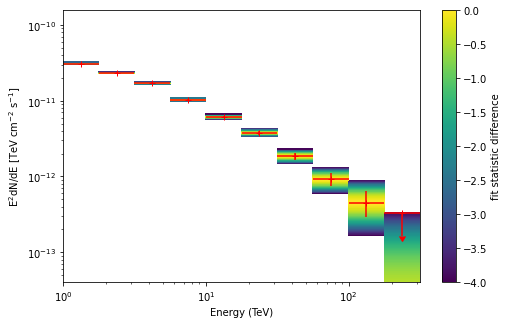

In [40]:
plt.figure(figsize=(8, 5))
ax = flux_points_hawc.plot(
    energy_power=2, color="red"
)
flux_points_hawc.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, cmap='viridis',  y_unit="TeV cm-2 s-1")
ax.set_ylabel("E$^2$dN/dE [TeV cm$^{-2}$ s$^{-1}$]")
plt.savefig("plots/hawc_flux_points.png", dpi=300, bbox_inches='tight')

In [41]:
#Energy Estimators
ref_model = LogParabolaSpectralModel(
    amplitude="2.35e-13 TeV-1 cm-2 s-1",
    alpha=2.79,
    beta=0.10,
    reference="7 TeV"
)
ref_model.amplitude.error = "0.04e-13 TeV-1 cm-2 s-1"
ref_model.beta.error = 0.02
ref_model.alpha.error = 0.01

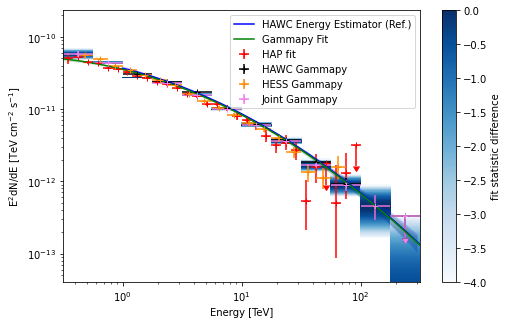

In [42]:
plt.figure(figsize=(8, 5))
flux_points_tim = FluxPoints.read('/nfs/d22/hin/vikasj78/crab_gammapy/hawc-gammapy/crab/crab_hess1_std_ImPACT_above20000_PL_fit.dat')
ax = flux_points_tim.plot(energy_power=2, label="HAP fit", color='red')
ref_model.plot(ax=ax, energy_range=(1.00, 316) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)",color='blue')
ref_model.plot_error(ax=ax, energy_range=(1.00, 316) * u.TeV, energy_power=2, color='blue')

#flux_points_hawc.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, y_unit="TeV cm-2 s-1", cmap='viridis')
flux_points_hawc.plot(ax=ax, energy_power=2, label="HAWC Gammapy", color="black")

#flux_points_hess.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, y_unit="TeV cm-2 s-1")
flux_points_hess.plot(ax=ax, energy_power=2, label="HESS Gammapy", color="darkorange")

flux_points_joint.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, y_unit="TeV cm-2 s-1")
flux_points_joint.plot(ax=ax, energy_power=2, label="Joint Gammapy", color='violet')
spectral_model.plot(ax=ax, energy_range=(0.316, 316) * u.TeV, energy_power=2, label="Gammapy Fit", color='green')
spectral_model.plot_error(ax=ax, energy_range=(0.316, 316) * u.TeV, energy_power=2, color='green')
ax.set_ylabel("E$^2$dN/dE [TeV cm$^{-2}$ s$^{-1}$]")
plt.legend()
plt.savefig("plots/total_sed.png", dpi=300, bbox_inches='tight')

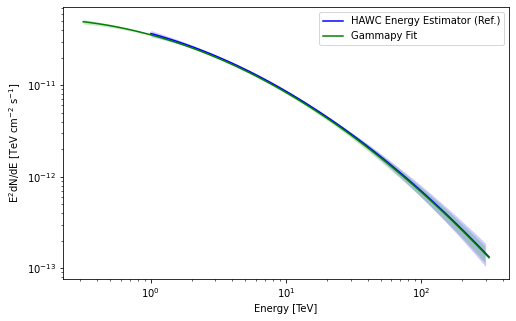

In [43]:
plt.figure(figsize=(8, 5))
ax = ref_model.plot(energy_range=(1.00, 316) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)",color='blue')
ref_model.plot_error(ax=ax, energy_range=(1.00, 316) * u.TeV, energy_power=2, color='blue')
spectral_model.plot(ax=ax, energy_range=(0.316, 316) * u.TeV, energy_power=2, label="Gammapy Fit", color='green')
spectral_model.plot_error(ax=ax, energy_range=(0.316, 316) * u.TeV, energy_power=2, color='green')
ax.set_ylabel("E$^2$dN/dE [TeV cm$^{-2}$ s$^{-1}$]")
plt.legend()
plt.savefig("plots/total_sed_without_flux_points.png", dpi=300, bbox_inches='tight')